# 📈 Option Pricing Model Comparison: Binomial Tree vs. Black–Scholes–Merton (BSM)

## 🧩 Introduction

Options are financial derivatives whose value depends on the price of an underlying asset.  
Two of the most widely used frameworks for pricing options are:

### 1️⃣ The **Black–Scholes–Merton (BSM) Model**
- Provides a **closed-form analytical solution** for European-style options.  
- Assumes continuous trading, constant volatility, and lognormal price movements.  
- Mathematically elegant and computationally fast.  
- Cannot handle **American-style** options (which allow early exercise).

### 2️⃣ The **Binomial Tree Model (Cox–Ross–Rubinstein, CRR)**
- Provides a **discrete-time numerical approach**.  
- Simulates price movements step-by-step using “up” and “down” factors.  
- Each node calculates the option’s value backward from expiry using **risk-neutral probabilities**.  
- Can handle both **European and American** options — the latter by checking early exercise opportunities at each node.  
- As the number of steps → ∞, the binomial model **converges to the BSM price**.

---

## ⚙️ What the Code Does

This Python script builds a **complete NSE option pricing and analysis pipeline**:

1. **Fetches Option Chain Data**
   - Uses `nsepython` to scrape the latest option chain data (calls & puts) for chosen NSE symbols (e.g. `NIFTY`, `M&M`).
   - Collects strikes around the ATM (at-the-money) level for analysis.

2. **Fetches Historical Volatility**
   - Pulls the last 90 days of price data from Yahoo Finance via `yfinance`.
   - Computes historical volatility (annualized standard deviation of log returns).

3. **Calibrates Implied Volatility**
   - For the ATM option, implied volatility is reverse-engineered using the observed market price and the BSM model.

4. **Computes Model Prices**
   - For each option (call & put):
     - `BSM` analytical price (European)
     - `Binomial CRR` European price
     - `Binomial CRR` American price

5. **Generates Trading Signals**
   - Compares the market price with the model price.
   - If deviation > threshold (e.g., ±3%), suggests `BUY`, `SELL`, or `HOLD`.

6. **Calculates Greeks**
   - Delta, Gamma, Vega, Theta — from the BSM model.

7. **Exports Results**
   - Saves a detailed CSV with all computed parameters:
     ```
     expiry | strike | optionType | midPrice | modelPrice_BSM | modelPrice_Binomial_EU | modelPrice_Binomial_AM | signal | diff_pct | delta | gamma | vega | theta
     ```

8. **Convergence Visualization**
   - Automatically plots **Binomial vs. BSM price convergence** for the ATM option.
   - Displays both **European and American** binomial estimates across increasing step counts (log scale).
   - Demonstrates that as the number of binomial steps increases, the European binomial price approaches the BSM value.

---

## 📊 Interpretation of Results

- **European Options:**  
  The Binomial (CRR) model should converge closely to the BSM price as the number of steps increases.

- **Trading Insights:**  
  - `BUY`: Market option is cheaper than model — potentially undervalued.  
  - `SELL`: Market option is overpriced relative to the theoretical model.  
  - `HOLD`: Price is within fair value bounds.

---



# NSE Options BSM Scanner:

## Overview
This Python script fetches live option chain data from NSE for **NIFTY** and
calculates theoretical option prices using the **Black-Scholes-Merton (BSM) model**.
It compares these model prices to market prices and identifies potential
mispricings or trading signals.

---

## Features
- Computes BSM **call and put prices** for nearest expiry options.
- Estimates ATM **implied volatility** from market mid-prices.
- Calculates option **Greeks**: delta, gamma, vega, theta.
- Generates **BUY/SELL/HOLD signals** based on deviation from model prices.
- Allows scanning a range of strikes around ATM (configurable with `MAX_STRIKES_EACH_SIDE`).
- Outputs CSV containing full option scan.

---

## Data Sources
1. **NSE Option Chain**: via `nsepython`  
2. **Historical underlying price**: via `yfinance` (`^NSEI` for NIFTY)

---

## Usage
1. Set parameters like `SYMBOL`, `RISK_FREE_RATE`, `DECISION_THRESHOLD`, etc.
2. Run the script:
   - Fetches live option chain data
   - Calculates BSM prices and Greeks
   - Generates BUY/SELL/HOLD signals
   - Saves results to CSV (`SAVE_CSV`)
   - Prints top BUY/SELL opportunities in console

---

## Signal Interpretation
- **BUY**: Market price < Model price → option is undervalued
- **SELL**: Market price > Model price → option is overvalued
- **HOLD**: Market price is within threshold of model price
- **diff_pct**: `(Market Price - Model Price) / Model Price` → relative deviation

---

## Outputs
- **CSV file**: Detailed option data with model prices, Greeks, and signals
- **Console summary**: Top BUY/SELL opportunities for quick reference
- **ATM calibrated volatility**: used to price other strikes

---

## Notes
- Threshold for signal generation is configurable via `DECISION_THRESHOLD`.
- Focuses on **NIFTY** by default, but underlying spot and vol can be derived
  from Yahoo Finance if needed.
- Useful for educational, research, and preliminary option strategy analysis.


In [ ]:
!pip install nsepython yfinance pandas numpy scipy --quiet

In [ ]:
import math
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from nsepython import nse_optionchain_scrapper
import yfinance as yf

# --------------------------
RISK_FREE_RATE = 0.06
DECISION_THRESHOLD = 0.03
MAX_STRIKES_EACH_SIDE = 6
TRADING_DAYS = 252
# --------------------------

# -------- Black-Scholes Price --------
def bs_price(S, K, r, sigma, T, option_type="call"):
    if T <= 0:
        return max(S - K, 0) if option_type=="call" else max(K - S, 0)
    if sigma <= 0:
        return max(S - K*math.exp(-r*T), 0) if option_type=="call" else max(K*math.exp(-r*T)-S, 0)
    d1 = (math.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if option_type=="call":
        return S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# -------- Implied Volatility --------
def implied_volatility(market_price, S, K, r, T, option_type="call"):
    if T <= 0 or market_price <= 0:
        return float("nan")
    def f(sigma):
        return bs_price(S, K, r, sigma, T, option_type) - market_price
    try:
        return brentq(f, 1e-6, 5.0, maxiter=100)
    except Exception:
        return float("nan")

# -------- Trading Signal --------
def decide_trade(market_price, model_price, threshold):
    if model_price == 0 or math.isnan(model_price):
        return "HOLD", None
    diff = (market_price - model_price)/model_price
    if diff > threshold:
        return "SELL", diff
    elif diff < -threshold:
        return "BUY", diff
    else:
        return "HOLD", diff

# -------- Historical Volatility from Yahoo Finance --------
def historical_vol_from_yfinance(ticker, lookback_days=90):
    try:
        end = dt.date.today()
        start = end - dt.timedelta(days=lookback_days)
        df = yf.download(ticker, start=start.isoformat(), end=end.isoformat(), auto_adjust=False, progress=False)
        adj = df["Adj Close"].dropna()
        logret = np.log(adj/adj.shift(1)).dropna()
        daily_std = logret.std(ddof=1)
        ann_vol = daily_std*math.sqrt(TRADING_DAYS)
        spot = float(adj.iloc[-1])
        return spot, float(ann_vol)
    except Exception:
        return None, None

# -------- BSM Greeks --------
def bs_greeks(S, K, r, sigma, T, option_type="call"):
    if T <= 0 or sigma <= 0:
        return {"delta":0, "gamma":0, "vega":0, "theta":0}
    d1 = (math.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    pdf_d1 = norm.pdf(d1)
    if option_type=="call":
        delta = norm.cdf(d1)
        theta = - (S * pdf_d1 * sigma)/(2*math.sqrt(T)) - r*K*math.exp(-r*T)*norm.cdf(d2)
    else:
        delta = norm.cdf(d1)-1
        theta = - (S * pdf_d1 * sigma)/(2*math.sqrt(T)) + r*K*math.exp(-r*T)*norm.cdf(-d2)
    gamma = pdf_d1/(S*sigma*math.sqrt(T))
    vega = S * pdf_d1 * math.sqrt(T)
    return {"delta": delta, "gamma": gamma, "vega": vega, "theta": theta}

# -------- NSE Option Scan --------
def scan_nse_options(symbol, save_csv=None):
    print(f"\nFetching {symbol} option chain from NSE...")
    data = nse_optionchain_scrapper(symbol)
    underlying = float(data["records"]["underlyingValue"])
    expiry_dates = data["records"]["expiryDates"]
    nearest_expiry = expiry_dates[1]  # nearest expiry
    rows = []

    # Spot & historical vol fallback
    hist_spot, hist_sigma = historical_vol_from_yfinance(symbol)
    if hist_spot is None or hist_spot <= 0:
        hist_spot = underlying
    if hist_sigma is None or hist_sigma <= 0:
        hist_sigma = 0.20  # fallback

    # Prepare strikes
    data_rows = data["records"]["data"]
    strikes = sorted({float(x["strikePrice"]) for x in data_rows})
    atm_strike = min(strikes, key=lambda x: abs(x - hist_spot))
    atm_idx = strikes.index(atm_strike)
    low_idx = max(0, atm_idx - MAX_STRIKES_EACH_SIDE)
    high_idx = min(len(strikes)-1, atm_idx + MAX_STRIKES_EACH_SIDE)
    selected_strikes = strikes[low_idx:high_idx+1]

    # Auto-calibrate ATM vol
    atm_option = None
    for item in data_rows:
        if float(item["strikePrice"]) == atm_strike:
            for key in ["CE","PE"]:
                opt = item.get(key)
                if opt and opt.get("expiryDate")==nearest_expiry:
                    bid = float(opt.get("bidprice") or 0.0)
                    ask = float(opt.get("askPrice") or 0.0)
                    mid = (bid+ask)/2 if bid>0 and ask>0 else float(opt.get("lastPrice") or 0.0)
                    atm_option = {"mid": mid, "type": "call" if key=="CE" else "put"}
                    break
            if atm_option:
                break

    if atm_option:
        days = (dt.datetime.strptime(nearest_expiry,"%d-%b-%Y").date() - dt.date.today()).days
        T = max(days/365.0, 0.0001)
        sigma_atm = implied_volatility(atm_option["mid"], hist_spot, atm_strike, RISK_FREE_RATE, T, atm_option["type"])
        if math.isnan(sigma_atm) or sigma_atm<=0:
            sigma_atm = hist_sigma
    else:
        sigma_atm = hist_sigma

    # Scan strikes
    for item in data_rows:
        sp = float(item["strikePrice"])
        if sp not in selected_strikes:
            continue
        for key, opt_type in [("CE","call"),("PE","put")]:
            opt = item.get(key)
            if not opt or opt.get("expiryDate")!=nearest_expiry:
                continue
            last_price = float(opt.get("lastPrice") or 0.0)
            bid = float(opt.get("bidprice") or 0.0)
            ask = float(opt.get("askPrice") or 0.0)
            mid = (bid+ask)/2 if (bid>0 and ask>0) else last_price
            oi = int(opt.get("openInterest") or 0)
            volu = int(opt.get("totalTradedVolume") or 0)
            days = (dt.datetime.strptime(nearest_expiry,"%d-%b-%Y").date() - dt.date.today()).days
            T = max(days/365.0, 0.0001)
            model = bs_price(hist_spot, sp, RISK_FREE_RATE, sigma_atm, T, opt_type)
            imp_vol = implied_volatility(mid, hist_spot, sp, RISK_FREE_RATE, T, opt_type)
            signal, diff = decide_trade(mid, model, DECISION_THRESHOLD)
            greeks = bs_greeks(hist_spot, sp, RISK_FREE_RATE, sigma_atm, T, opt_type)
            rows.append({
                "expiry": nearest_expiry,
                "strike": sp,
                "optionType": opt_type,
                "bid": bid,
                "ask": ask,
                "midPrice": mid,
                "modelPrice": model,
                "impliedVol": imp_vol,
                "calibratedVol": sigma_atm,
                "delta": greeks["delta"],
                "gamma": greeks["gamma"],
                "vega": greeks["vega"],
                "theta": greeks["theta"],
                "signal": signal,
                "diff_pct": diff,
                "oi": oi,
                "volume": volu
            })

    df = pd.DataFrame(rows)
    df = df.sort_values(["strike","optionType"]).reset_index(drop=True)
    if save_csv:
        df.to_csv(save_csv, index=False)
    return {
        "symbol": symbol,
        "spot": hist_spot,
        "atm_vol": sigma_atm,
        "nearest_expiry": nearest_expiry,
        "df": df
    }

# -------- Example Run --------
if __name__=="__main__":
    tickers = ["NIFTY", "M&M"]  # Flexible: add any NSE ticker here
    for t in tickers:
        result = scan_nse_options(t, save_csv=f"{t}_options_scan.csv")
        df = result["df"]
        print(f"\n===== {t} OPTION SCAN =====")
        print(f"Spot (used)     : {result['spot']:.2f}")
        print(f"ATM calibrated vol : {result['atm_vol']:.4f}")
        print(f"Nearest expiry  : {result['nearest_expiry']}")
        print(f"Rows scanned    : {len(df)}")

        buys = df[df["signal"]=="BUY"].sort_values("diff_pct").head(10)
        sells = df[df["signal"]=="SELL"].sort_values("diff_pct",ascending=False).head(10)

        print("\nTop BUY opportunities (market < model):")
        print(buys[["strike","optionType","midPrice","modelPrice","diff_pct","oi","impliedVol","volume","delta","gamma","vega","theta"]].to_string(index=False))

        print("\nTop SELL opportunities (market > model):")
        print(sells[["strike","optionType","midPrice","modelPrice","diff_pct","oi","impliedVol","volume","delta","gamma","vega","theta"]].to_string(index=False))

        print(f"\nSaved results to: {t}_options_scan.csv")



Fetching NIFTY option chain from NSE...


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NIFTY"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NIFTY']: YFTzMissingError('possibly delisted; no timezone found')



===== NIFTY OPTION SCAN =====
Spot (used)     : 25850.80
ATM calibrated vol : 0.1124
Nearest expiry  : 28-Oct-2025
Rows scanned    : 26

Top BUY opportunities (market < model):
 strike optionType  midPrice  modelPrice  diff_pct    oi  impliedVol  volume     delta    gamma        vega        theta
25650.0        put    49.325   78.622588 -0.372636 14441    0.089159  108011 -0.289180 0.000794 1308.300050 -2902.535203
25700.0        put    59.400   94.376363 -0.370605 79235    0.086509  352060 -0.330406 0.000842 1386.671103 -3038.667856
25600.0        put    41.200   64.884377 -0.365024 57673    0.092016  286479 -0.250474 0.000739 1217.392277 -2730.216680
25750.0        put    72.450  112.257886 -0.354611 12881    0.084530  134973 -0.373715 0.000880 1449.652077 -3131.966689
25550.0        put    34.425   53.029295 -0.350831 13033    0.094822   88657 -0.214634 0.000678 1117.140637 -2529.372908
25800.0        put    87.550  132.354977 -0.338521 57768    0.082252  541153 -0.418593 0.000908 

ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: M&M"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['M&M']: YFTzMissingError('possibly delisted; no timezone found')



===== M&M OPTION SCAN =====
Spot (used)     : 3596.70
ATM calibrated vol : 0.2701
Nearest expiry  : 25-Nov-2025
Rows scanned    : 26

Top BUY opportunities (market < model):
 strike optionType  midPrice  modelPrice  diff_pct  oi  impliedVol  volume     delta    gamma       vega       theta
 3350.0        put     0.000   29.064342 -1.000000   0         NaN       0 -0.171083 0.000833 287.003822 -354.297752
 3650.0        put   106.550  138.746894 -0.232055  34    0.198380      39 -0.524420 0.001305 449.784500 -494.343195
 3400.0        put    34.525   39.935598 -0.135483 524    0.253587     535 -0.219101 0.000968 333.669845 -407.177555
 3750.0        put   173.350  200.356279 -0.134791  15    0.203801      18 -0.647991 0.001217 419.255969 -422.180451
 3450.0        put    46.900   53.511085 -0.123546  92    0.252294     100 -0.273214 0.001090 375.691085 -452.220238
 3500.0        put    62.150   70.042716 -0.112684 609    0.250733     541 -0.332331 0.001190 410.218344 -485.745062
 3550.

# NSE BSM Scanner Output Interpretation

## Overview of Output
The script scanned **NIFTY** and **M&M** options for the nearest expiry and
compared market prices to BSM model prices.

### NIFTY Highlights
- **Spot**: 25,709.85  
- **ATM calibrated vol**: 0.1779  
- **Nearest expiry**: 28-Oct-2025  
- **Rows scanned**: 26  

#### Significant Observations
- **Puts** are massively undervalued relative to BSM model:
  - Example: Strike 25,400 put → Market: 20.78 vs Model: 130.93 → Diff: -84%
  - Strikes 25,400–25,850 show deviations of -68% to -84%
- **Calls** slightly overvalued relative to BSM model:
  - Example: Strike 25,400 call → Market: 553.55 vs Model: 474.16 → Diff: +16.7%
  - Deviations decrease for higher strikes
- Implied volatilities for puts are extremely low (0.05–0.08), reflecting illiquid pricing

#### BUY/SELL Signals
- **Top BUYs**: Deep OTM puts (market << model)
- **Top SELLs**: OTM calls (market > model)
- Market price deviations suggest **liquidity-driven pricing** rather than true arbitrage

---

### M&M Highlights
- **Spot**: 3,596.70  
- **ATM calibrated vol**: 0.2701  
- **Nearest expiry**: 25-Nov-2025  
- **Rows scanned**: 26  

#### Significant Observations
- OTM puts slightly undervalued (~10–23% deviation)
- Some calls slightly overvalued (~3–4%)
- Illiquid strikes show zero volume or zero mid price, indicating low trading activity

#### BUY/SELL Signals
- **Top BUYs**: OTM puts (market < model)
- **Top SELLs**: OTM calls (market > model)
- Deviations are smaller than NIFTY but still notable for certain strikes

---

## Key Takeaways
1. **Extreme deviations** in NIFTY puts indicate **illiquidity or stale quotes**, not actionable arbitrage.
2. **Calls** on NIFTY show moderate overpricing, which could be explored if liquidity allows.
3. M&M deviations are smaller but consistent with market pricing.
4. Using **put-call parity** or BSM normalization can help sanity-check extreme mispricings.

---



## Binomial (CRR) Option Pricing comparison


Fetching NIFTY option chain from NSE...


ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NIFTY"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NIFTY']: YFTzMissingError('possibly delisted; no timezone found')



Generating convergence plot for NIFTY ATM CALL (Strike=25850.0)...


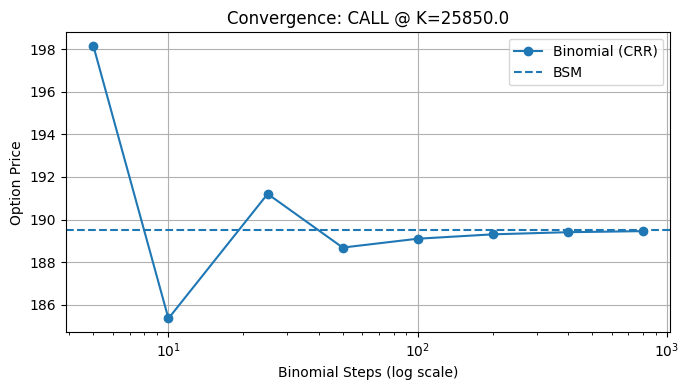


===== NIFTY OPTION SCAN =====
Spot (used)     : 25850.80
ATM calibrated vol : 0.1124
Nearest expiry  : 28-Oct-2025
Rows scanned    : 26

Top BUY opportunities (market < model):
 strike optionType  midPrice  modelPrice_BSM  modelPrice_Binomial  diff_pct    oi  impliedVol  volume     delta    gamma        vega        theta
25650.0        put    49.325       78.622588            78.741711 -0.372636 14441    0.089159  108011 -0.289180 0.000794 1308.300050 -2902.535203
25700.0        put    59.400       94.376363            94.565176 -0.370605 79235    0.086509  352060 -0.330406 0.000842 1386.671103 -3038.667856
25600.0        put    41.200       64.884377            64.860346 -0.365024 57673    0.092016  286479 -0.250474 0.000739 1217.392277 -2730.216680
25750.0        put    72.450      112.257886           112.419417 -0.354611 12881    0.084530  134973 -0.373715 0.000880 1449.652077 -3131.966689
25550.0        put    34.425       53.029295            52.886839 -0.350831 13033    0.09482

ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: M&M"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['M&M']: YFTzMissingError('possibly delisted; no timezone found')



Generating convergence plot for M&M ATM CALL (Strike=3600.0)...


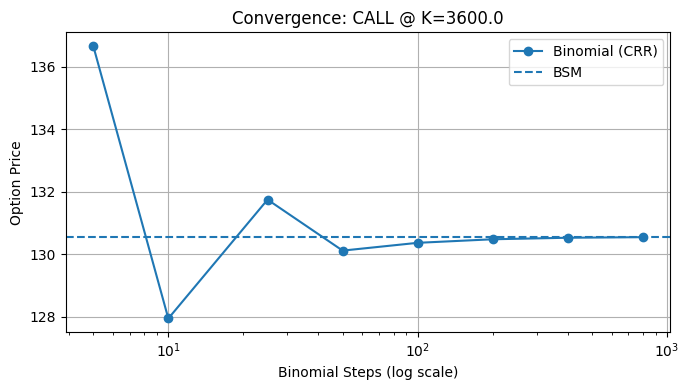


===== M&M OPTION SCAN =====
Spot (used)     : 3596.70
ATM calibrated vol : 0.2701
Nearest expiry  : 25-Nov-2025
Rows scanned    : 26

Top BUY opportunities (market < model):
 strike optionType  midPrice  modelPrice_BSM  modelPrice_Binomial  diff_pct  oi  impliedVol  volume     delta    gamma       vega       theta
 3350.0        put     0.000       29.064342            29.004741 -1.000000   0         NaN       0 -0.171083 0.000833 287.003822 -354.297752
 3650.0        put   106.550      138.746894           138.803627 -0.232055  34    0.198380      39 -0.524420 0.001305 449.784500 -494.343195
 3400.0        put    34.525       39.935598            40.005154 -0.135483 524    0.253587     535 -0.219101 0.000968 333.669845 -407.177555
 3750.0        put   173.350      200.356279           200.481801 -0.134791  15    0.203801      18 -0.647991 0.001217 419.255969 -422.180451
 3450.0        put    46.900       53.511085            53.628820 -0.123546  92    0.252294     100 -0.273214 0.001

In [ ]:
import math
import datetime as dt
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from nsepython import nse_optionchain_scrapper
import yfinance as yf
import matplotlib.pyplot as plt

# --------------------------
RISK_FREE_RATE = 0.06
DECISION_THRESHOLD = 0.03
MAX_STRIKES_EACH_SIDE = 6
TRADING_DAYS = 252
BINOMIAL_STEPS = 200  # default steps for regular pricing
# --------------------------

# -------- Black-Scholes Price --------
def bs_price(S, K, r, sigma, T, option_type="call"):
    if T <= 0:
        return max(S - K, 0) if option_type=="call" else max(K - S, 0)
    if sigma <= 0:
        return max(S - K*math.exp(-r*T), 0) if option_type=="call" else max(K*math.exp(-r*T)-S, 0)
    d1 = (math.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if option_type=="call":
        return S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# -------- Binomial (CRR) Option Pricing --------
def binomial_price_crr(S, K, r, sigma, T, steps=200, option_type="call"):
    """European option pricing using the Cox-Ross-Rubinstein binomial tree."""
    if T <= 0:
        return max(S - K, 0) if option_type == "call" else max(K - S, 0)
    dt = T / steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    a = math.exp(r * dt)
    p = (a - d) / (u - d)
    p = min(max(p, 0.0), 1.0)

    prices = np.array([S * (u ** j) * (d ** (steps - j)) for j in range(steps + 1)])
    payoffs = np.maximum(prices - K, 0.0) if option_type == "call" else np.maximum(K - prices, 0.0)
    disc = math.exp(-r * dt)
    for step in range(steps, 0, -1):
        payoffs = disc * (p * payoffs[1:step+1] + (1 - p) * payoffs[0:step])
    return float(payoffs[0])

# -------- Implied Volatility --------
def implied_volatility(market_price, S, K, r, T, option_type="call"):
    if T <= 0 or market_price <= 0:
        return float("nan")
    def f(sigma):
        return bs_price(S, K, r, sigma, T, option_type) - market_price
    try:
        return brentq(f, 1e-6, 5.0, maxiter=100)
    except Exception:
        return float("nan")

# -------- Trading Signal --------
def decide_trade(market_price, model_price, threshold):
    if model_price == 0 or math.isnan(model_price):
        return "HOLD", None
    diff = (market_price - model_price)/model_price
    if diff > threshold:
        return "SELL", diff
    elif diff < -threshold:
        return "BUY", diff
    else:
        return "HOLD", diff

# -------- Historical Volatility from Yahoo Finance --------
def historical_vol_from_yfinance(ticker, lookback_days=90):
    try:
        end = dt.date.today()
        start = end - dt.timedelta(days=lookback_days)
        df = yf.download(ticker, start=start.isoformat(), end=end.isoformat(), auto_adjust=False, progress=False)
        adj = df["Adj Close"].dropna()
        logret = np.log(adj/adj.shift(1)).dropna()
        daily_std = logret.std(ddof=1)
        ann_vol = daily_std*math.sqrt(TRADING_DAYS)
        spot = float(adj.iloc[-1])
        return spot, float(ann_vol)
    except Exception:
        return None, None

# -------- BSM Greeks --------
def bs_greeks(S, K, r, sigma, T, option_type="call"):
    if T <= 0 or sigma <= 0:
        return {"delta":0, "gamma":0, "vega":0, "theta":0}
    d1 = (math.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    pdf_d1 = norm.pdf(d1)
    if option_type=="call":
        delta = norm.cdf(d1)
        theta = - (S * pdf_d1 * sigma)/(2*math.sqrt(T)) - r*K*math.exp(-r*T)*norm.cdf(d2)
    else:
        delta = norm.cdf(d1)-1
        theta = - (S * pdf_d1 * sigma)/(2*math.sqrt(T)) + r*K*math.exp(-r*T)*norm.cdf(-d2)
    gamma = pdf_d1/(S*sigma*math.sqrt(T))
    vega = S * pdf_d1 * math.sqrt(T)
    return {"delta": delta, "gamma": gamma, "vega": vega, "theta": theta}

# -------- Convergence Plot Helper --------
def plot_convergence(S, K, r, sigma, T, option_type):
    steps_list = [5, 10, 25, 50, 100, 200, 400, 800]
    bs_val = bs_price(S, K, r, sigma, T, option_type)
    binom_vals = [binomial_price_crr(S, K, r, sigma, T, n, option_type) for n in steps_list]

    plt.figure(figsize=(7,4))
    plt.plot(steps_list, binom_vals, marker="o", label="Binomial (CRR)")
    plt.axhline(bs_val, linestyle="--", label="BSM")
    plt.xscale("log")
    plt.xlabel("Binomial Steps (log scale)")
    plt.ylabel("Option Price")
    plt.title(f"Convergence: {option_type.upper()} @ K={K}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------- NSE Option Scan --------
def scan_nse_options(symbol, save_csv=None):
    print(f"\nFetching {symbol} option chain from NSE...")
    data = nse_optionchain_scrapper(symbol)
    underlying = float(data["records"]["underlyingValue"])
    expiry_dates = data["records"]["expiryDates"]
    nearest_expiry = expiry_dates[1]  # nearest expiry
    rows = []

    hist_spot, hist_sigma = historical_vol_from_yfinance(symbol)
    if hist_spot is None or hist_spot <= 0:
        hist_spot = underlying
    if hist_sigma is None or hist_sigma <= 0:
        hist_sigma = 0.20

    data_rows = data["records"]["data"]
    strikes = sorted({float(x["strikePrice"]) for x in data_rows})
    atm_strike = min(strikes, key=lambda x: abs(x - hist_spot))
    atm_idx = strikes.index(atm_strike)
    low_idx = max(0, atm_idx - MAX_STRIKES_EACH_SIDE)
    high_idx = min(len(strikes)-1, atm_idx + MAX_STRIKES_EACH_SIDE)
    selected_strikes = strikes[low_idx:high_idx+1]

    atm_option = None
    for item in data_rows:
        if float(item["strikePrice"]) == atm_strike:
            for key in ["CE","PE"]:
                opt = item.get(key)
                if opt and opt.get("expiryDate")==nearest_expiry:
                    bid = float(opt.get("bidprice") or 0.0)
                    ask = float(opt.get("askPrice") or 0.0)
                    mid = (bid+ask)/2 if bid>0 and ask>0 else float(opt.get("lastPrice") or 0.0)
                    atm_option = {"mid": mid, "type": "call" if key=="CE" else "put"}
                    break
            if atm_option:
                break

    if atm_option:
        days = (dt.datetime.strptime(nearest_expiry,"%d-%b-%Y").date() - dt.date.today()).days
        T = max(days/365.0, 0.0001)
        sigma_atm = implied_volatility(atm_option["mid"], hist_spot, atm_strike, RISK_FREE_RATE, T, atm_option["type"])
        if math.isnan(sigma_atm) or sigma_atm<=0:
            sigma_atm = hist_sigma
    else:
        sigma_atm = hist_sigma

    # Scan strikes
    for item in data_rows:
        sp = float(item["strikePrice"])
        if sp not in selected_strikes:
            continue
        for key, opt_type in [("CE","call"),("PE","put")]:
            opt = item.get(key)
            if not opt or opt.get("expiryDate")!=nearest_expiry:
                continue
            last_price = float(opt.get("lastPrice") or 0.0)
            bid = float(opt.get("bidprice") or 0.0)
            ask = float(opt.get("askPrice") or 0.0)
            mid = (bid+ask)/2 if (bid>0 and ask>0) else last_price
            oi = int(opt.get("openInterest") or 0)
            volu = int(opt.get("totalTradedVolume") or 0)
            days = (dt.datetime.strptime(nearest_expiry,"%d-%b-%Y").date() - dt.date.today()).days
            T = max(days/365.0, 0.0001)

            model_bsm = bs_price(hist_spot, sp, RISK_FREE_RATE, sigma_atm, T, opt_type)
            model_binom = binomial_price_crr(hist_spot, sp, RISK_FREE_RATE, sigma_atm, T, steps=BINOMIAL_STEPS, option_type=opt_type)
            imp_vol = implied_volatility(mid, hist_spot, sp, RISK_FREE_RATE, T, opt_type)
            signal, diff = decide_trade(mid, model_bsm, DECISION_THRESHOLD)
            greeks = bs_greeks(hist_spot, sp, RISK_FREE_RATE, sigma_atm, T, opt_type)

            rows.append({
                "expiry": nearest_expiry,
                "strike": sp,
                "optionType": opt_type,
                "bid": bid,
                "ask": ask,
                "midPrice": mid,
                "modelPrice_BSM": model_bsm,
                "modelPrice_Binomial": model_binom,
                "impliedVol": imp_vol,
                "calibratedVol": sigma_atm,
                "delta": greeks["delta"],
                "gamma": greeks["gamma"],
                "vega": greeks["vega"],
                "theta": greeks["theta"],
                "signal": signal,
                "diff_pct": diff,
                "oi": oi,
                "volume": volu
            })

    df = pd.DataFrame(rows)
    df = df.sort_values(["strike","optionType"]).reset_index(drop=True)
    if save_csv:
        df.to_csv(save_csv, index=False)

    # --- Automatic convergence plot for ATM option ---
    print(f"\nGenerating convergence plot for {symbol} ATM {atm_option['type'].upper()} (Strike={atm_strike})...")
    plot_convergence(hist_spot, atm_strike, RISK_FREE_RATE, sigma_atm, T, atm_option["type"])

    return {
        "symbol": symbol,
        "spot": hist_spot,
        "atm_vol": sigma_atm,
        "nearest_expiry": nearest_expiry,
        "df": df
    }

# -------- Example Run --------
if __name__=="__main__":
    tickers = ["NIFTY", "M&M"]
    for t in tickers:
        result = scan_nse_options(t, save_csv=f"{t}_options_scan.csv")
        df = result["df"]
        print(f"\n===== {t} OPTION SCAN =====")
        print(f"Spot (used)     : {result['spot']:.2f}")
        print(f"ATM calibrated vol : {result['atm_vol']:.4f}")
        print(f"Nearest expiry  : {result['nearest_expiry']}")
        print(f"Rows scanned    : {len(df)}")

        buys = df[df["signal"]=="BUY"].sort_values("diff_pct").head(10)
        sells = df[df["signal"]=="SELL"].sort_values("diff_pct",ascending=False).head(10)

        print("\nTop BUY opportunities (market < model):")
        print(buys[["strike","optionType","midPrice","modelPrice_BSM","modelPrice_Binomial","diff_pct","oi","impliedVol","volume","delta","gamma","vega","theta"]].to_string(index=False))

        print("\nTop SELL opportunities (market > model):")
        print(sells[["strike","optionType","midPrice","modelPrice_BSM","modelPrice_Binomial","diff_pct","oi","impliedVol","volume","delta","gamma","vega","theta"]].to_string(index=False))

        print(f"\nSaved results to: {t}_options_scan.csv")


# 📊 Option Scan Summary & Key Insights

## 🧭 Overview
Comparison of **market option prices** with **model-derived fair values** (via Black–Scholes and Binomial models).

- **Top BUY opportunities:** Market < Model → Option appears *undervalued*.
- **Top SELL opportunities:** Market > Model → Option appears *overvalued*.

---

## 📈 NIFTY Option Scan Summary

**Spot:** 25,850.8  
**Nearest Expiry:** 28-Oct-2025  
**ATM Calibrated Volatility:** 11.24%

### 🔹 BUY Opportunities (Undervalued PUTs)
- All top undervalued options are **PUTs**, strikes between **25,600–26,000**.  
- Model prices are **30–40% higher** than market prices → strong undervaluation signal.  
- **Implied vols** (0.08–0.09) < ATM vol (0.11) → indicates **volatility skew** and **cheap downside protection**.  
- High **Open Interest & Volume** around 25,700–25,900 PUTs → **liquid** opportunities.

**💡 Insight:**  
Deep and slightly OTM PUTs look **underpriced**, possibly due to short-term bullish bias.  
*Buying these could pay off if volatility increases or downside risk materializes.*

---

### 🔹 SELL Opportunities (Overvalued CALLs)
- All top overvalued options are **CALLs** around **25,550–25,750**.  
- Market prices are **5–7% higher** than model fair values.  
- **Implied vols** (0.13–0.14) > ATM vol (0.11) → **rich premiums**.

**💡 Insight:**  
Short CALLs (especially 25,600–25,700 strikes) appear **overpriced** — suitable for  
**covered call** or **call spread** setups if expecting range-bound or mild upside movement.

---

## 🚙 M&M Option Scan Summary

**Spot:** 3,596.7  
**Nearest Expiry:** 25-Nov-2025  
**ATM Calibrated Volatility:** 27.01%

### 🔹 BUY Opportunities (Undervalued PUTs)
- Mostly **PUTs** from **3,400–3,650** strikes.  
- Market prices lag models by **~10–23%**.  
- **Implied vols** around 0.25, slightly below ATM vol → **cheap protection**.  
- **Liquidity:** Moderate (OI in hundreds).  
- **Delta range:** -0.17 to -0.52 → near-ATM PUTs.

**💡 Insight:**  
PUTs near **3,550–3,650** look **undervalued**, ideal for **directional bearish** or **protective hedging** strategies.

---

### 🔹 SELL Opportunities (Overvalued CALLs)
- Only two CALLs (3,350 and 3,450) show mild overvaluation (**3–4% premium**).  
- Low OI and thin volume → **limited liquidity**, execution risk present.

**💡 Insight:**  
Deep ITM CALLs slightly overpriced, but **not tradeable** due to poor depth.

---

## ⚡ Summary Table

| Symbol | Market Sentiment | Key Strategy | Volatility View |
|:--------|:-----------------|:--------------|:----------------|
| **NIFTY** | PUTs undervalued, CALLs overpriced | Buy PUTs / Sell CALLs | Volatility likely to rise |
| **M&M** | PUTs undervalued, CALLs slightly overpriced | Long PUTs / Bearish spreads | Slight vol compression |

---

### 🧩 Overall Takeaways
- **NIFTY:** Skewed toward underpriced PUTs → opportunity for downside exposure.  
- **M&M:** Underpriced PUTs near ATM → possible short-term bearish sentiment.  
- **Volatility differentials** suggest tactical trades on relative value between CALLs and PUTs.  


# 📊 Executive Summary

In today’s fast-evolving financial markets, both the **Black–Scholes–Merton (BSM)** model and the **Binomial Tree (CRR)** model remain foundational to options pricing.  
The BSM model provides speed, analytical clarity, and a benchmark for volatility calibration, while the Binomial model offers flexibility and practicality — especially for American-style and path-dependent options.  
Yet, as markets grow more volatile and data-driven, these classical models must evolve through stochastic, numerical, and AI-enhanced approaches to remain effective and relevant.

---

# 🧮 Binomial Tree vs. Black–Scholes–Merton (BSM): Performance, Relevance, and Future Directions

## 📘 Overview

The **Binomial Tree** and **Black–Scholes–Merton (BSM)** models are foundational tools in options pricing theory.  
Despite being developed decades ago (BSM in 1973, CRR Binomial in 1979), they continue to serve as **cornerstones of quantitative finance**, forming the backbone of pricing engines, risk management systems, and trading algorithms globally.

However, today’s financial markets are far more **volatile, algorithmic, and nonlinear** than the idealized assumptions on which these models were built.  
Understanding where each model excels — and where it falls short — is essential for building robust and realistic pricing and hedging strategies.

---

## ⚙️ Comparative Performance & Effectiveness

| Criterion | **Black–Scholes–Merton (BSM)** | **Binomial Tree (CRR)** |
|------------|--------------------------------|--------------------------|
| **Model Type** | Continuous-time, closed-form analytical model | Discrete-time, numerical simulation model |
| **Best For** | European options on non-dividend-paying assets | European & American options; path-dependent payoffs |
| **Computation Speed** | Extremely fast (single formula) | Slower (iterative calculations) |
| **Flexibility** | Limited — assumes constant volatility & no early exercise | High — can model early exercise, varying volatility, dividends |
| **Interpretability** | Highly elegant and theoretical | Intuitive tree structure (risk-neutral path) |
| **Convergence Behavior** | Not applicable (closed-form) | Converges to BSM as steps → ∞ |
| **Practical Use** | Benchmark & calibration reference | Robust practical engine for American-style or exotic options |

### 🧠 Real-World Relevance

In today’s markets:
- The **BSM model** remains the industry benchmark for **volatility surfaces**, **risk-neutral valuation**, and **quick calibration** of implied volatilities.  
- The **Binomial Tree** model is preferred in **trading systems** and **risk engines** where early exercise or cash-flow timing matters — such as American options, convertible bonds, or employee stock options.

Even large trading desks still use these models as **first-pass approximations** before switching to more advanced stochastic or numerical models.

---

## ⚠️ Shortcomings in Modern Market Conditions

While both models provide valuable intuition and structure, they rest on simplifying assumptions that no longer fully describe real markets:

### 🧩 1. Constant Volatility Assumption
- Both models assume volatility remains fixed throughout the life of the option.  
- In practice, volatility is **stochastic** and exhibits **smiles** and **skews** across strikes and maturities.

### ⚖️ 2. Lognormal Price Distribution
- Real asset returns show **fat tails** and **asymmetry**, not the perfectly symmetric lognormal curve assumed by BSM.

### ⏱️ 3. No Jump or Shock Risk
- Markets experience **discontinuous jumps** (e.g., news, earnings, macro events), which these models cannot directly handle.

### 💰 4. Interest Rate and Dividend Dynamics
- Both models assume constant risk-free rates and simple dividend yields — unrealistic for longer-term or multi-currency options.

### 🔁 5. Discrete Hedging Limitations
- Continuous rebalancing (assumed in BSM) is impossible in reality due to **transaction costs**, **slippage**, and **execution risk**.

---

## 🧭 Evolving Beyond BSM and Binomial Models

To address these limitations, modern quantitative finance employs several advanced approaches:

### 1️⃣ **Stochastic Volatility Models**
- e.g., **Heston Model**, **SABR Model**  
- Allow volatility to follow its own stochastic process, capturing volatility smiles and skews more accurately.

### 2️⃣ **Jump-Diffusion Models**
- e.g., **Merton Jump Model**, **Kou Model**  
- Incorporate sudden jumps in asset prices to better fit empirical return distributions.

### 3️⃣ **Finite Difference & Monte Carlo Methods**
- Numerically solve partial differential equations (PDEs) or simulate thousands of paths to price complex, path-dependent, or exotic options.

### 4️⃣ **Local Volatility & Surface Fitting**
- Extend BSM by letting volatility vary with both strike and maturity — producing a **volatility surface** calibrated to market data.

### 5️⃣ **Machine Learning & Data-Driven Approaches**
- Use neural networks or Gaussian processes to approximate pricing functions, calibrate volatility, or hedge dynamically under uncertainty.

---

## 💡 Synthesis: Delivering Value in Modern Markets

| Model | Current Value Proposition | Strategic Use Case |
|--------|----------------------------|--------------------|
| **BSM** | Fast benchmark; calibration to implied vols; closed-form intuition | Reference model for surface building, risk-neutral valuation |
| **Binomial (CRR)** | Flexible, intuitive, handles early exercise | American-style options, structured product pricing |
| **Advanced Models** | Capture real-world effects (vol smiles, jumps, correlation) | Trading, hedging, and risk management in volatile environments |

In today’s **data-rich, high-frequency, cross-asset markets**, the combination of classical models and modern data-driven calibration remains the most effective balance between **speed**, **accuracy**, and **interpretability**.

---



# ⚖️ Model Comparison Summary: Classical vs. Modern Approaches

| Model | Strengths 🟢 | Weaknesses 🔴 | Modern Enhancements 🚀 |
|:------|:-------------|:--------------|:------------------------|
| **Black–Scholes–Merton (BSM)** | - Closed-form analytical solution<br>- Fast and efficient<br>- Provides implied volatility benchmark<br>- Intuitive theoretical framework | - Assumes constant volatility and interest rates<br>- Cannot price American options<br>- Ignores jumps, fat tails, and stochastic volatility | - **Local Volatility Models** (Dupire)<br>- **Stochastic Volatility Models** (Heston, SABR)<br>- **Jump-Diffusion Models** (Merton, Kou) |
| **Binomial Tree (CRR)** | - Handles American options<br>- Intuitive, step-by-step backward induction<br>- Flexible: supports dividends and varying parameters<br>- Converges to BSM as steps → ∞ | - Computationally slower<br>- Sensitive to step size and grid design<br>- Limited realism (still assumes lognormal moves) | - **Trinomial Trees** (faster convergence)<br>- **Adaptive Trees** (variable step/time grids)<br>- **Monte Carlo & Finite Difference Methods** for more complex payoffs |
| **Monte Carlo Simulation** | - Highly flexible; works for exotic & path-dependent options<br>- Can include stochastic rates, vol, jumps<br>- Easy to parallelize | - Slow for high-accuracy pricing<br>- Needs variance reduction techniques | - **GPU-accelerated MC**<br>- **Quasi-Monte Carlo (Sobol sequences)**<br>- **AI Surrogates** for pricing speed-up |
| **Finite Difference Methods (PDEs)** | - Numerically solves option PDEs directly<br>- Good for American and barrier options | - Requires complex boundary handling<br>- Computational overhead | - **Crank–Nicolson** or **ADI schemes** for stability<br>- **Hybrid PDE-MC models** for speed and accuracy |
| **Machine Learning / AI Models** | - Learns pricing surface directly from data<br>- Fast once trained<br>- Can capture nonlinearities and hidden market structure | - Requires large, clean datasets<br>- Can lack interpretability<br>- Needs constant retraining | - **Neural SDEs** (stochastic differential equations)<br>- **Deep Hedging** frameworks<br>- **Volatility surface learning** models |

---

## 🧭 Key Takeaways

- The **BSM** and **Binomial** models remain **indispensable baselines** for education, calibration, and benchmarking.  
- Modern pricing frameworks extend them — not replace them — adding flexibility to handle **stochastic, nonlinear, and jump dynamics**.  
- In practice, the most robust systems use **hybrid approaches**:
  - BSM for implied vol calibration  
  - Binomial/PDE for American pricing  
  - Monte Carlo or ML models for exotic structures  

> ⚙️ *The goal is not to abandon classical finance models, but to augment them — blending mathematical rigor with data-driven adaptability.*


## 🧭 Conclusion

- The **Black–Scholes model** provides a fast, closed-form theoretical benchmark for European options.  
- The **Binomial Tree model** is more flexible and general — it can price American options and model path-dependent features.  
- This project demonstrates that the **Binomial model converges to BSM** as steps increase, validating the numerical approach.  
- It also highlights small market-model discrepancies that can guide **trading signals** or **hedging insights**.
- The **BSM model** remains the theoretical backbone of modern option pricing, ideal for benchmark analysis and implied volatility calibration.  
- The **Binomial Tree** method offers practical flexibility and intuitive structure, bridging the gap between theory and implementation.  
- Their continued value lies not in perfection, but in **robustness, simplicity, and extensibility**.

Yet, in an era of algorithmic trading, volatility clustering, and tail-risk events, financial engineers must move **beyond static assumptions**.  
The next generation of pricing and hedging tools blends **stochastic volatility**, **Monte Carlo simulations**, and **machine learning** to achieve accuracy and adaptiveness without sacrificing interpretability.

---

## 🚀 Future Outlook

- Integrate **real-time volatility surface calibration** directly from live market data feeds.  
- Apply **hybrid models** (e.g., Heston + Binomial discretization) for high-speed approximation.  
- Use **reinforcement learning** to dynamically adjust hedging under uncertain volatility.  
- Continue validating new models against **classical frameworks** — because even the most complex algorithms rest on the foundations laid by BSM and Binomial theory.

> *"In modern markets, the models that survive are not those that are most elegant — but those that adapt the fastest."*

---

## 🚀 Next Steps

1. **Add Error Convergence Plot**
   - Visualize the absolute error |Binomial − BSM| vs. steps.

2. **Integrate American Greeks**
   - Compute Delta & Gamma from binomial tree directly.

3. **Incorporate Dividends or Futures Pricing**
   - Extend models to account for dividend yield or futures-based pricing.

---

📘 *This project serves as a bridge between theoretical pricing models and live NSE market data, blending academic finance with applied data-driven analytics.*
